In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
device_lib.list_local_devices()


2025-08-29 14:03:10.550594: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 14:03:10.728408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-29 14:03:10.728442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-29 14:03:10.729162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-29 14:03:10.811875: I tensorflow/core/platform/cpu_feature_g

TensorFlow version: 2.14.0
Num GPUs Available: 1


2025-08-29 14:03:13.574379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-29 14:03:13.591287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-29 14:03:13.591319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-29 14:03:13.593461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-29 14:03:13.593485: I tensorflow/compile

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12273020752558061384
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5825888256
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11534019100811836615
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

ead NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-29 14:03:13.759879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 5556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 24000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 aug_style (Sequential)      (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7,

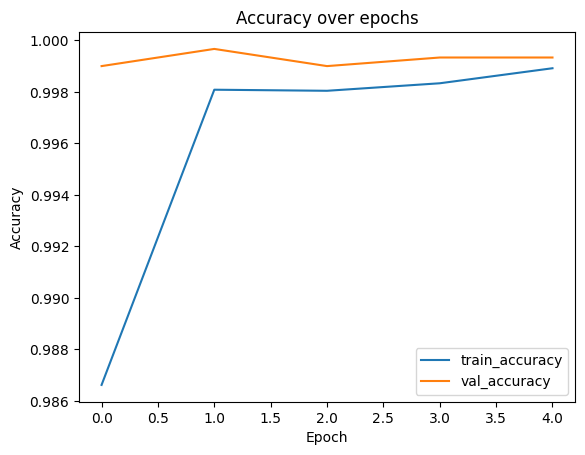

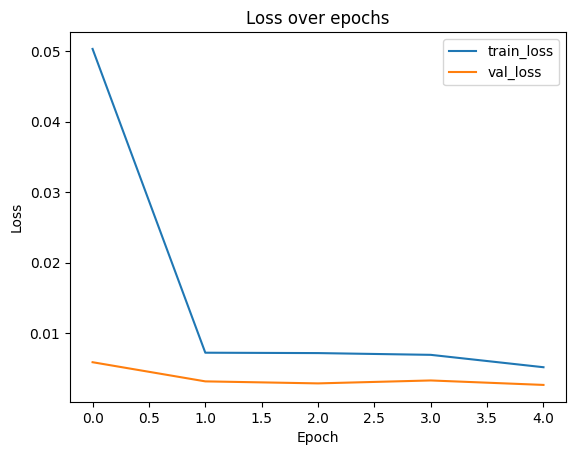

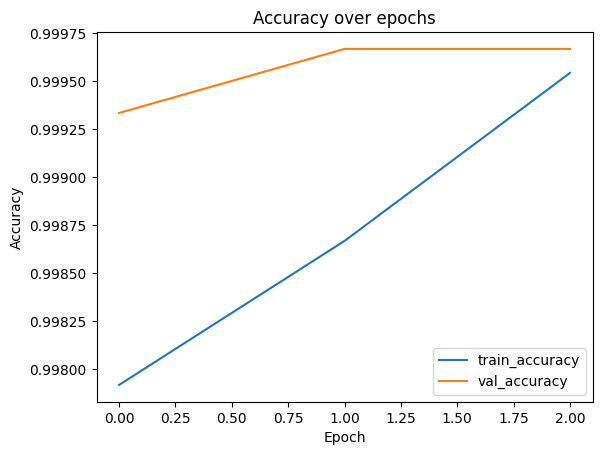

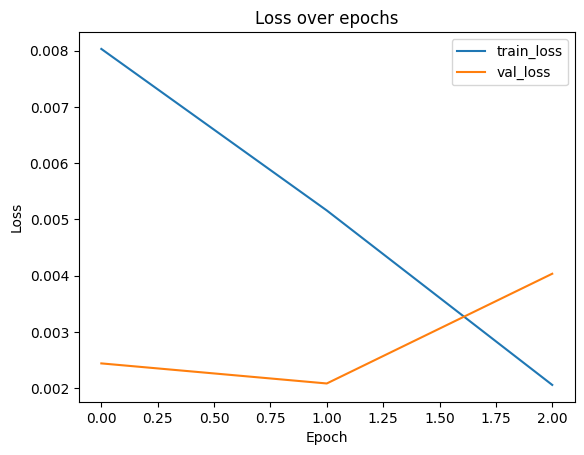

              precision    recall  f1-score   support

       human     1.0000    0.9990    0.9995      1000
      avatar     1.0000    1.0000    1.0000      1000
   not human     0.9990    1.0000    0.9995      1000

    accuracy                         0.9997      3000
   macro avg     0.9997    0.9997    0.9997      3000
weighted avg     0.9997    0.9997    0.9997      3000



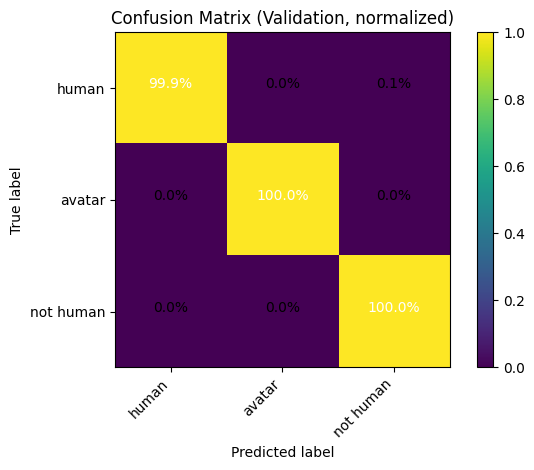

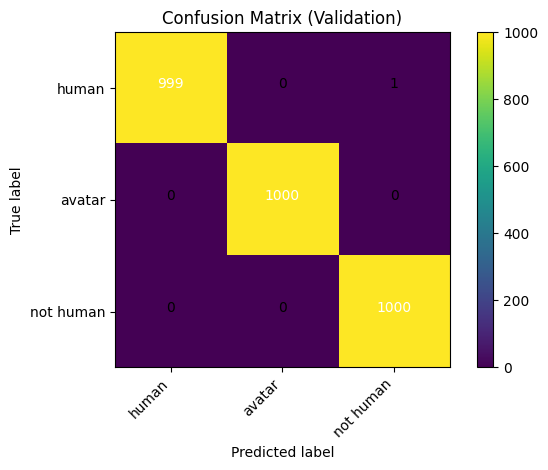

In [29]:
# %% [markdown]
# CNN multi-classifier: human vs avatar vs "not human" (animal)
# Directory layout:
# ./data/final/train/{animal,avatar,human}
# ./data/final/val/{animal,avatar,human}

# %% Imports & setup
import os, json, random, itertools, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

# Optional: enable GPU memory growth (helps with VRAM fragmentation)
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass
        
SEED = 42
tf.keras.utils.set_random_seed(SEED)
# try:
#     tf.config.experimental.enable_op_determinism()
# except Exception:
#     pass

# Classes on disk and how we want to display them
CLASS_NAMES_IN  = ['human', 'avatar', 'animal']   # folder names
CLASS_NAMES_OUT = ['human', 'avatar', 'not human']

# Paths
BASE = pathlib.Path(".")
TRAIN_DIR = BASE / "data" / "final" / "train"
VAL_DIR   = BASE / "data" / "final" / "val"

# Training hyperparams
IMG_SIZE   = (224, 224)
BATCH_SIZE = 16          # drop to 8 if VRAM is tight
EPOCHS     = 10          # raise later after it’s stable
LR         = 1e-3

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int',
    class_names=CLASS_NAMES_IN, image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, seed=SEED, shuffle=False
).shuffle(1000, seed=SEED).prefetch(AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, labels='inferred', label_mode='int',
    class_names=CLASS_NAMES_IN, image_size=IMG_SIZE,
    batch_size=BATCH_SIZE, seed=SEED, shuffle=False
).prefetch(AUTOTUNE)

# # %% Model: MobileNetV2 backbone + small head
# # Data augmentation runs on-the-fly and only during training
# data_augmentation = keras.Sequential([
#     layers.RandomFlip('horizontal'),
#     layers.RandomRotation(0.05),
#     layers.RandomZoom(0.1),
# ])

# --- Style-focused augmentation (replace your current data_augmentation) ---
# If your TF/Keras has these layers:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),     # style/texture robustness
    layers.RandomBrightness(0.2),   # Keras 2.13+ / TF 2.13+
], name="aug_style")

base = keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # first stage: freeze backbone

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
# ensure final Dense outputs float32
outputs = layers.Dense(3, activation='softmax', dtype='float32')(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ---- Stage 1 (feature-extractor) ----
callbacks_stage1 = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
    keras.callbacks.ModelCheckpoint(
        filepath='best_stage1.weights.h5',
        save_best_only=True,
        save_weights_only=True,   # <- important
        monitor='val_accuracy'
    ),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
]
history_stage1 = model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=callbacks_stage1)

# ---- Fine-tune setup ----
base.trainable = True
for layer in base.layers[:-80]:
    layer.trainable = False
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Use weights-only OR SavedModel dir here
callbacks_stage2 = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy'),
    keras.callbacks.ModelCheckpoint(
        filepath='best_stage2.weights.h5',
        save_best_only=True,
        save_weights_only=True,   # <- important
        monitor='val_accuracy'
    ),
    # Alternative to the above line:
    # keras.callbacks.ModelCheckpoint('best_stage2', save_best_only=True, monitor='val_accuracy'),  # SavedModel dir
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6),
]
history_stage2 = model.fit(train_ds, epochs=3, validation_data=val_ds, callbacks=callbacks_stage2)

# (Optional) ensure best fine-tuned weights are loaded before eval
model.load_weights('best_stage2.weights.h5')

# # %% Train (stage 1: frozen backbone)
# print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
# print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
# print("CLASS_NAMES_IN:", CLASS_NAMES_IN)
# print("Display labels:", CLASS_NAMES_OUT)

# callbacks_ft = [
#     keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy'),
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_stage2.weights.h5',
#         save_best_only=True,
#         save_weights_only=True,   # <-- important
#         monitor='val_accuracy'
#     ),
#     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6),
# ]
# history_ft = model.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=callbacks_ft)

# # Unfreeze the top of the backbone and fine-tune
# base.trainable = True
# for layer in base.layers[:-40]:
#     layer.trainable = False

# # Freeze all BatchNorm layers in the backbone
# for layer in base.layers:
#     if isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False

# model.compile(
#     optimizer=keras.optimizers.Adam(1e-4),  # smaller LR for fine-tuning
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_ft = model.fit(
#     train_ds,
#     epochs=5,  # adjust as needed
#     validation_data=val_ds,
#     callbacks=[
#         keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy'),
#         keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
#         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
#     ]
# )

def plot_history(hist, metric='accuracy'):
    plt.figure()
    plt.plot(hist.history[metric], label=f'train_{metric}')
    plt.plot(hist.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'{metric.capitalize()} over epochs')
    plt.show()

# %% Plot training curves
plot_history(history_stage1, 'accuracy')
plot_history(history_stage1, 'loss')
plot_history(history_stage2, 'accuracy')
plot_history(history_stage2, 'loss')

# plot_history(history, 'accuracy')
# plot_history(history, 'loss')

# %% Evaluate & Confusion Matrix on validation set
# Collect true labels
y_true = []
for _, y in val_ds.unbatch():
    y_true.append(int(y.numpy()))
y_true = np.array(y_true)

# Predict probabilities then argmax
y_prob = model.predict(val_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Classification report
print(classification_report(
    y_true, y_pred, target_names=CLASS_NAMES_OUT, digits=4
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

# Normalized (row-wise) confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, interpolation='nearest')
plt.title('Confusion Matrix (Validation, normalized)')
plt.colorbar()
tick_marks = np.arange(len(CLASS_NAMES_OUT))
plt.xticks(tick_marks, CLASS_NAMES_OUT, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES_OUT)
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%", ha="center",
             color="white" if cm_norm[i, j] > 0.5 else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


def plot_confusion_matrix(cm, class_names):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')  # default colormap
    plt.title('Confusion Matrix (Validation)')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2. if cm.max() > 0 else 0.5
    # annotate cells
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, CLASS_NAMES_OUT)

# %% Save model + label mapping for inference
model.save('human_avatar_not_human.keras')
with open('label_mapping.json', 'w') as f:
    json.dump({
        "indices_in": CLASS_NAMES_IN,     # ['human', 'avatar', 'animal']
        "indices_out": CLASS_NAMES_OUT    # ['human', 'avatar', 'not human']
    }, f, indent=2)

# %% Helper: classify a single new image
def predict_image(path):
    img = keras.utils.load_img(path, target_size=IMG_SIZE)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return {
        "predicted_index": idx,
        "predicted_label": CLASS_NAMES_OUT[idx],
        "probs": {CLASS_NAMES_OUT[i]: float(probs[i]) for i in range(3)}
    }

def predict_image_tta(path, n_flips=1):
    """
    Predict with simple test-time augmentation (original + horizontal flips).
    IMPORTANT: do NOT preprocess here — your model already does it inside.
    """
    img = keras.utils.load_img(path, target_size=IMG_SIZE, color_mode="rgb")
    x = keras.utils.img_to_array(img)[None, ...]  # (1, H, W, 3), 0..255

    views = [x]
    for _ in range(n_flips):
        views.append(x[:, :, ::-1, :])  # horizontal flip

    probs = []
    for v in views:
        probs.append(model.predict(v, verbose=0)[0])  # model graph handles preprocess_input
    probs = np.stack(probs, axis=0).mean(axis=0)

    idx = int(np.argmax(probs))
    return {
        "predicted_index": idx,
        "predicted_label": CLASS_NAMES_OUT[idx],
        "probs": {CLASS_NAMES_OUT[i]: float(probs[i]) for i in range(3)}
    }

# Example:
# print(predict_image("some_image.jpg"))


In [25]:
from pathlib import Path
import csv

def classify_directory(dir_path="data/my", save_csv=None, batch_size=64):
    """
    Classify all JPG/JPEG/PNG files under dir_path (recursively) using the current `model`.
    Returns (results_list, pandas_df_or_None).
    """
    exts = {".jpg", ".jpeg", ".png"}
    files = sorted(str(p) for p in Path(dir_path).rglob("*") if p.suffix.lower() in exts)
    if not files:
        print(f"No images found in {dir_path} (looked for {sorted(exts)}).")
        return [], None

    results = []
    for i in range(0, len(files), batch_size):
        batch_paths = files[i:i+batch_size]
        batch = []
        for fp in batch_paths:
            img = keras.utils.load_img(fp, target_size=IMG_SIZE, color_mode="rgb")
            arr = keras.utils.img_to_array(img)  # shape (H,W,3), values 0..255
            batch.append(arr)
        x = np.stack(batch, axis=0)             # DO NOT preprocess here! Model handles it.

        probs = model.predict(x, verbose=0)     # model graph includes preprocess_input
        idxs  = probs.argmax(axis=1)

        for j, fp in enumerate(batch_paths):
            results.append({
                "file": fp,
                "predicted": CLASS_NAMES_OUT[idxs[j]],
                CLASS_NAMES_OUT[0]: float(probs[j, 0]),  # 'human'
                CLASS_NAMES_OUT[1]: float(probs[j, 1]),  # 'avatar'
                CLASS_NAMES_OUT[2]: float(probs[j, 2]),  # 'not human'
            })

    df = None
    if save_csv:
        try:
            import pandas as pd
            df = pd.DataFrame(results)
            df.to_csv(save_csv, index=False)
        except Exception:
            with open(save_csv, "w", newline="") as fp:
                writer = csv.DictWriter(fp, fieldnames=list(results[0].keys()))
                writer.writeheader()
                writer.writerows(results)
        print(f"Saved predictions to {save_csv}")

    print(f"Classified {len(results)} images. Sample:")
    for row in results[:5]:
        fname = Path(row['file']).name
        print(
            f"{fname:30s} -> {row['predicted']} "
            f"(human={row['human']:.3f}, avatar={row['avatar']:.3f}, not human={row['not human']:.3f})"
        )
    return results, df


In [26]:
results, df = classify_directory("data/my", save_csv="my_preds.csv")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Saved predictions to my_preds.csv
Classified 14 images. Sample:
avatar01.jpg                   -> human (human=1.000, avatar=0.000, not human=0.000)
avatar02.jpg                   -> human (human=0.992, avatar=0.000, not human=0.008)
avatar03.jpg                   -> avatar (human=0.000, avatar=1.000, not human=0.000)
avatar04.jpg                   -> avatar (human=0.001, avatar=0.994, not human=0.005)
avatar05.jpg                   -> human (human=1.000, avatar=0.000, not human=0.000)


In [49]:
# from pathlib import Path
# import math
# import matplotlib.pyplot as plt
# import numpy as np
# from tensorflow import keras

# def show_predictions_gallery(
#     dir_path="data/my",
#     batch_size=64,
#     cols=4,
#     max_images=None,
#     show_probs=True,
#     save_figure=None,
# ):
#     """
#     Display a gallery of images with filename and predicted label (+ confidence).
#     Uses the global `model`, `IMG_SIZE`, and `CLASS_NAMES_OUT`.

#     Args:
#       dir_path: folder to scan (recursive).
#       batch_size: prediction batch size.
#       cols: number of columns in the grid.
#       max_images: limit total images shown (None = all).
#       show_probs: include class probabilities on each tile.
#       save_figure: path to save the gallery as an image (e.g., 'report.png').

#     Returns:
#       A list of dicts with file, predicted, and per-class probabilities.
#     """
#     exts = {".jpg", ".jpeg", ".png"}
#     files = sorted(str(p) for p in Path(dir_path).rglob("*") if p.suffix.lower() in exts)
#     if not files:
#         print(f"No images found in {dir_path} (looked for {sorted(exts)}).")
#         return []

#     if max_images is not None:
#         files = files[:max_images]

#     # Predict in mini-batches (note: model handles preprocess_input internally)
#     all_arrays = []   # keep resized arrays so we can display them without reloading
#     all_probs  = []
#     for i in range(0, len(files), batch_size):
#         batch_paths = files[i:i+batch_size]
#         batch = []
#         for fp in batch_paths:
#             img = keras.utils.load_img(fp, target_size=IMG_SIZE, color_mode="rgb")
#             arr = keras.utils.img_to_array(img)   # 0..255
#             batch.append(arr)
#         x = np.stack(batch, axis=0)
#         probs = model.predict(x, verbose=0)      # shape (B, 3)
#         all_arrays.extend(batch)
#         all_probs.append(probs)

#     probs = np.concatenate(all_probs, axis=0) if all_probs else np.array([])
#     preds = probs.argmax(axis=1)
#     confs = probs.max(axis=1)

#     # Build results list (also handy for CSV later)
#     results = []
#     for i, fp in enumerate(files):
#         results.append({
#             "file": fp,
#             "predicted": CLASS_NAMES_OUT[preds[i]],
#             CLASS_NAMES_OUT[0]: float(probs[i, 0]),
#             CLASS_NAMES_OUT[1]: float(probs[i, 1]),
#             CLASS_NAMES_OUT[2]: float(probs[i, 2]),
#         })

#     # --- Draw gallery ---
#     n = len(files)
#     rows = math.ceil(n / cols)
#     # Heuristic: each cell ~3x3 inches; tweak as you like
#     fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.5))
#     if rows == 1 and cols == 1:
#         axes = np.array([[axes]])
#     elif rows == 1:
#         axes = np.array([axes])
#     elif cols == 1:
#         axes = np.array([[ax] for ax in axes])

#     for idx in range(rows * cols):
#         r, c = divmod(idx, cols)
#         ax = axes[r, c]
#         ax.axis("off")
#         if idx >= n:
#             continue
#         img = all_arrays[idx].astype(np.uint8)   # already 224x224
#         ax.imshow(img)
#         fname = Path(files[idx]).name
#         label = CLASS_NAMES_OUT[preds[idx]]
#         conf  = confs[idx]
#         if show_probs:
#             subtitle = (f"{label} ({conf*100:.1f}%)\n"
#                         f"h={probs[idx,0]:.2f}, a={probs[idx,1]:.2f}, nh={probs[idx,2]:.2f}")
#         else:
#             subtitle = f"{label} ({conf*100:.1f}%)"
#         ax.set_title(f"{fname}\n{subtitle}", fontsize=9)

#     plt.tight_layout()
#     if save_figure:
#         plt.savefig(save_figure, dpi=160, bbox_inches='tight')
#         print(f"Saved gallery to {save_figure}")
#     plt.show()

#     return results



from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from textwrap import shorten

def show_predictions_gallery(dir_path="data/my", cols=4, max_images=None,
                             batch_size=64, use_tta=False,
                             row_gap=0.22, col_gap=0.25,
                             title_fs=9, title_pad=5,
                             name_width=28, show_probs=True):
    exts = {".jpg", ".jpeg", ".png"}
    files = sorted(str(p) for p in Path(dir_path).rglob("*") if p.suffix.lower() in exts)
    if not files:
        print(f"No images found in {dir_path}")
        return []

    if max_images is not None:
        files = files[:max_images]

    imgs, probs_list = [], []
    if use_tta:
        for fp in files:
            r = predict_image_tta(fp)
            probs_list.append([r["probs"][k] for k in CLASS_NAMES_OUT])
            img = keras.utils.load_img(fp, target_size=IMG_SIZE, color_mode="rgb")
            imgs.append(keras.utils.img_to_array(img).astype(np.uint8))
        probs = np.array(probs_list)
    else:
        batches = []
        for i in range(0, len(files), batch_size):
            chunk = files[i:i+batch_size]
            x = []
            for fp in chunk:
                img = keras.utils.load_img(fp, target_size=IMG_SIZE, color_mode="rgb")
                arr = keras.utils.img_to_array(img)
                imgs.append(arr.astype(np.uint8))
                x.append(arr)
            x = np.stack(x, axis=0)
            batches.append(model.predict(x, verbose=0))
        probs = np.concatenate(batches, axis=0) if batches else np.zeros((0, 3))

    preds = probs.argmax(axis=1)
    confs = probs.max(axis=1)

    results = []
    for i, fp in enumerate(files):
        results.append({
            "file": fp,
            "predicted": CLASS_NAMES_OUT[preds[i]],
            CLASS_NAMES_OUT[0]: float(probs[i, 0]),
            CLASS_NAMES_OUT[1]: float(probs[i, 1]),
            CLASS_NAMES_OUT[2]: float(probs[i, 2]),
        })

    n = len(files)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.8))
    fig.subplots_adjust(hspace=row_gap, wspace=col_gap)

    axes = np.atleast_2d(axes)
    for idx in range(rows * cols):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        ax.axis("off")
        if idx >= n:
            continue

        fname = shorten(Path(files[idx]).name, width=name_width, placeholder='…')
        label = CLASS_NAMES_OUT[preds[idx]]

        # Bold prediction line via mathtext; escape the percent sign
        pred_line = rf"$\bf{{pred:\ {label}\ ({confs[idx]*100:.1f}\%)}}$"

        lines = [fname, pred_line]
        if show_probs:
            lines += [
                f"human: {probs[idx,0]:.2f}",
                f"avatar: {probs[idx,1]:.2f}",
                f"not human: {probs[idx,2]:.2f}",
            ]
        ax.set_title("\n".join(lines), fontsize=title_fs, pad=title_pad)

        ax.imshow(imgs[idx])

    plt.show()
    return results




# from textwrap import shorten

# def show_predictions_gallery(dir_path="data/my", cols=4, max_images=None,
#                              batch_size=64, use_tta=False,
#                              row_gap=1.0, col_gap=0.25,
#                              title_fs=9, title_pad=10, name_width=30):
#     exts = {".jpg", ".jpeg", ".png"}
#     files = sorted(str(p) for p in Path(dir_path).rglob("*") if p.suffix.lower() in exts)
#     if not files:
#         print(f"No images found in {dir_path}")
#         return []

#     if max_images is not None:
#         files = files[:max_images]

#     imgs, probs_all = [], []
#     if use_tta:
#         for fp in files:
#             r = predict_image_tta(fp)
#             probs_all.append([r["probs"][k] for k in CLASS_NAMES_OUT])
#             img = keras.utils.load_img(fp, target_size=IMG_SIZE, color_mode="rgb")
#             imgs.append(keras.utils.img_to_array(img).astype(np.uint8))
#         probs = np.array(probs_all)
#     else:
#         batches = []
#         for i in range(0, len(files), batch_size):
#             chunk = files[i:i+batch_size]
#             x = []
#             for fp in chunk:
#                 img = keras.utils.load_img(fp, target_size=IMG_SIZE, color_mode="rgb")
#                 arr = keras.utils.img_to_array(img)
#                 imgs.append(arr.astype(np.uint8))
#                 x.append(arr)
#             x = np.stack(x, axis=0)
#             batches.append(model.predict(x, verbose=0))
#         probs = np.concatenate(batches, axis=0)

#     preds = probs.argmax(axis=1)
#     confs = probs.max(axis=1)

#     results = []
#     for i, fp in enumerate(files):
#         results.append({
#             "file": fp,
#             "predicted": CLASS_NAMES_OUT[preds[i]],
#             CLASS_NAMES_OUT[0]: float(probs[i, 0]),
#             CLASS_NAMES_OUT[1]: float(probs[i, 1]),
#             CLASS_NAMES_OUT[2]: float(probs[i, 2]),
#         })

#     n = len(files)
#     rows = math.ceil(n / cols)

#     # Make each row a bit taller and add gaps
#     fig, axes = plt.subplots(
#         rows, cols,
#         figsize=(cols * 3.2, rows * 4.0),          # taller per row
#         gridspec_kw={'wspace': col_gap, 'hspace': row_gap}  # gaps
#     )

#     axes = np.atleast_2d(axes)
#     for idx in range(rows * cols):
#         r, c = divmod(idx, cols)
#         ax = axes[r, c]
#         ax.axis("off")
#         if idx >= n:
#             continue

#         ax.imshow(imgs[idx])

#         fname = shorten(Path(files[idx]).name, width=name_width, placeholder='…')
#         label = CLASS_NAMES_OUT[preds[idx]]
#         subtitle = f"{label} ({confs[idx]*100:.1f}%) [h={probs[idx,0]:.2f}, a={probs[idx,1]:.2f}, nh={probs[idx,2]:.2f}]"

#         # More space between image and its title; truncate long names
#         ax.set_title(f"{fname}\n{subtitle}", fontsize=title_fs, pad=title_pad)

#     # Avoid tight_layout here since it can override hspace/wspace
#     plt.show()
#     return results


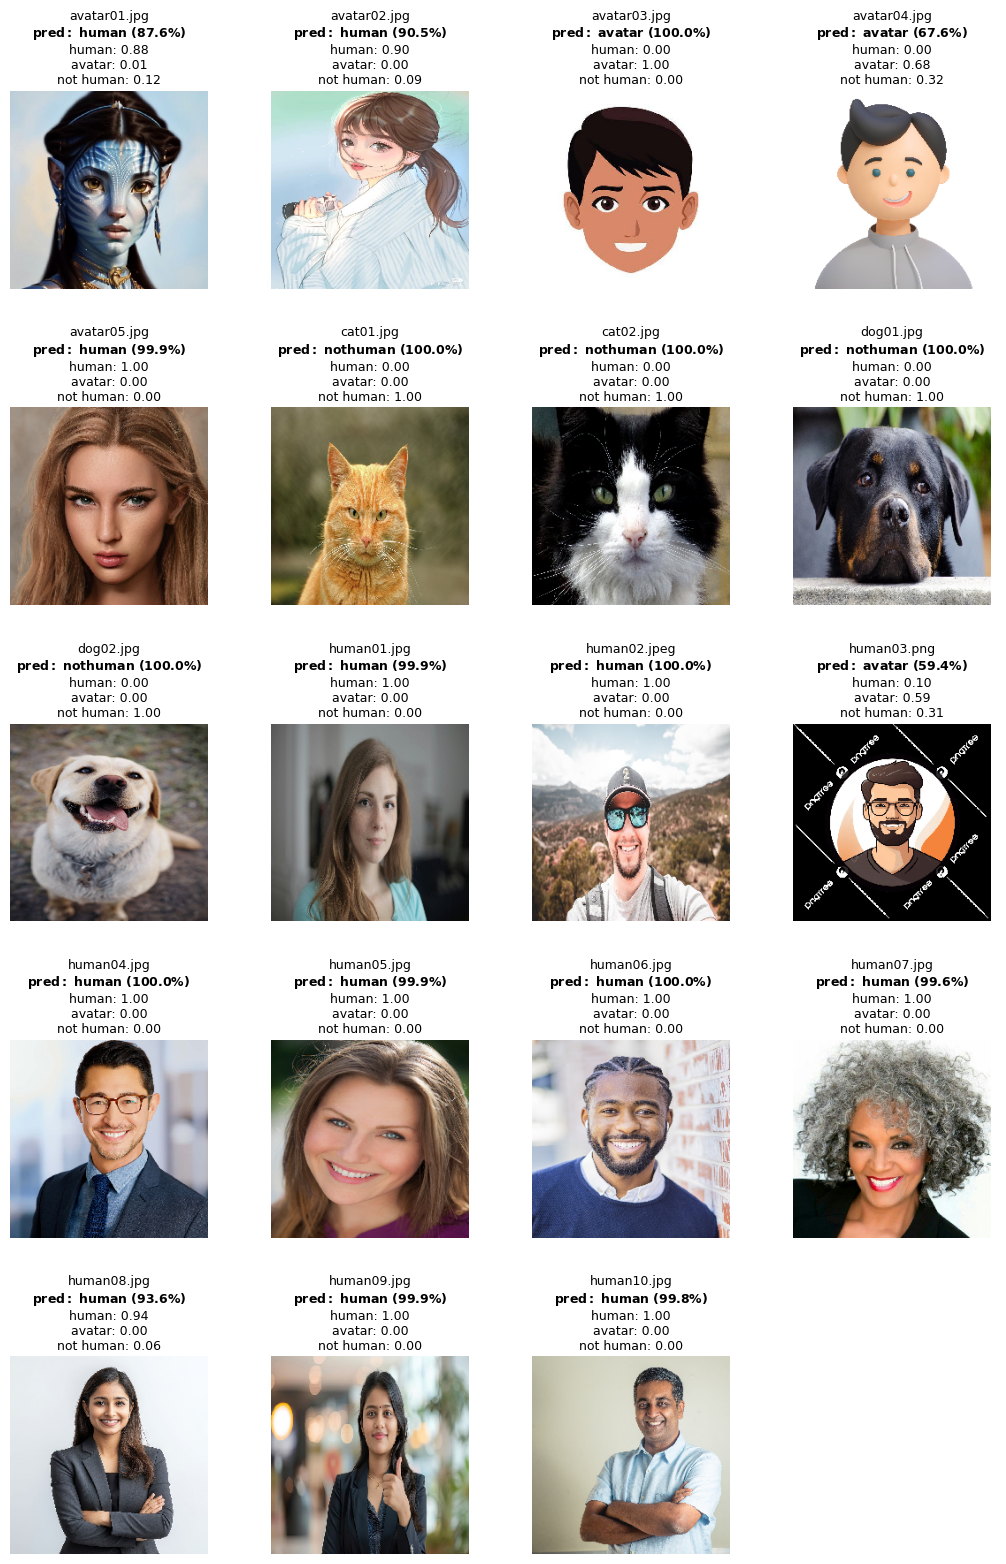

In [52]:
# Quick on-screen report for up to 24 images, 4 across
# results = show_predictions_gallery("data/my", cols=4, max_images=24, save_figure="my_report.png")
_ = show_predictions_gallery("data/my", cols=4, max_images=24, use_tta=True, row_gap=0.6)

Just gettin' started!

In [17]:
import pandas as pd
import os
import shutil
import random
from pathlib import Path
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications.resnet50 import preprocess_input


In [193]:
# Load the FairFace CSV file
df = pd.read_csv("data/fairface_label_train.csv")

In [194]:
df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [195]:
df.shape

(86744, 5)

In [196]:
df['age'].unique()

array(['50-59', '30-39', '3-9', '20-29', '40-49', '10-19', '60-69', '0-2',
       'more than 70'], dtype=object)

In [197]:
# It's highly unlikely that kids under the age of 20 are working in this organization.
df = df[~df['age'].isin(['0-2', '3-9', '10-19'])]

In [198]:
df.shape

(65441, 5)

In [199]:
print(df['race'].unique())
print(df['gender'].unique())

['East Asian' 'Indian' 'White' 'Middle Eastern' 'Latino_Hispanic'
 'Southeast Asian' 'Black']
['Male' 'Female']


In [200]:
# Stratified sampling: race × gender
# samples_per_group = 500

# df_balanced = (
#     df.groupby(['race', 'gender']).apply(
#         lambda x: x.sample(min(len(x), samples_per_group), random_state=42).assign(race=x['race'].iloc[0], gender=x['gender'].iloc[0]),
#         include_groups=False
#     )
#     .reset_index(drop=True)
# )
samples_per_group = 500

grouped = df.groupby(['race', 'gender'], group_keys=False)
df_balanced = pd.concat([
    group.sample(min(len(group), samples_per_group), random_state=42)
    for _, group in grouped
], ignore_index=True)

In [201]:
group_counts = df_balanced.groupby(['race', 'gender']).size().reset_index(name='count')
print(group_counts)

               race  gender  count
0             Black  Female    500
1             Black    Male    500
2        East Asian  Female    500
3        East Asian    Male    500
4            Indian  Female    500
5            Indian    Male    500
6   Latino_Hispanic  Female    500
7   Latino_Hispanic    Male    500
8    Middle Eastern  Female    500
9    Middle Eastern    Male    500
10  Southeast Asian  Female    500
11  Southeast Asian    Male    500
12            White  Female    500
13            White    Male    500


In [202]:
print(df_balanced.columns)

Index(['file', 'age', 'gender', 'race', 'service_test'], dtype='object')


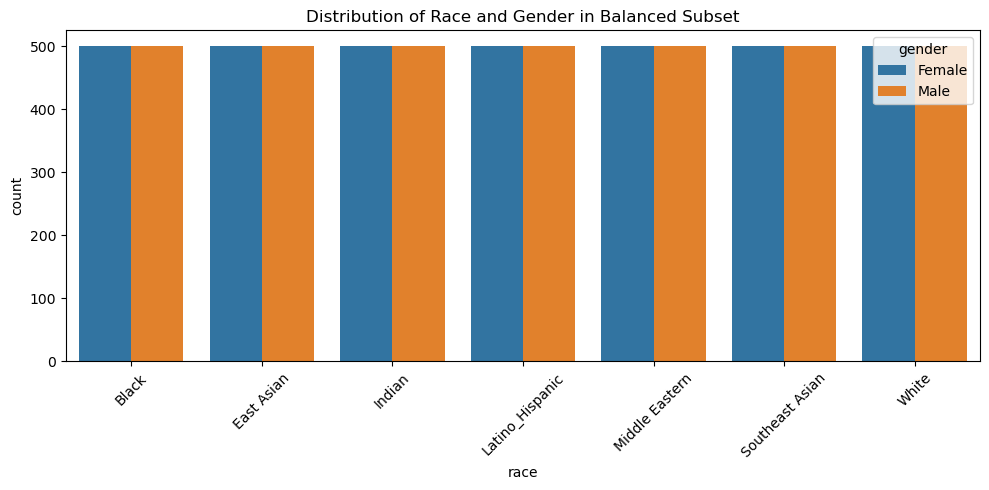

In [203]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_balanced, x='race', hue='gender')
plt.title('Distribution of Race and Gender in Balanced Subset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [204]:
# Save selected subset
df_balanced.to_csv("data/fairface_subset.csv", index=False)

In [205]:
# # Copy images to output folder
# src_img_dir = "data/fairface-img-margin125-trainval/train"
# dst_img_dir = "dataset/human/"
# os.makedirs(dst_img_dir, exist_ok=True)

# # Strip 'train/' prefix from file column if present
# df_balanced['file'] = df_balanced['file'].apply(lambda x: os.path.basename(x))

# for img in df_balanced['file']:
#     src_path = os.path.join(src_img_dir, img)
#     dst_path = os.path.join(dst_img_dir, img)
#     if os.path.exists(src_path):
#         shutil.copy(src_path, dst_path)

In [206]:
# Define source paths
fairface_dir = Path("DATA/fairface-img-margin125-trainval/train")
cat_dir = Path("DATA/animal-faces/afhq/train/cat")
dog_dir = Path("DATA/animal-faces/afhq/train/dog")

# Define destination paths
dest_human = Path("DATA/binary_classifier/train/human")
dest_animal = Path("DATA/binary_classifier/train/animal")
dest_human.mkdir(parents=True, exist_ok=True)
dest_animal.mkdir(parents=True, exist_ok=True)

# Select 7000 random human faces
human_files = list(fairface_dir.glob("*.jpg"))
selected_human = random.sample(human_files, 7000)
for file in selected_human:
    shutil.copy(file, dest_human / file.name)

# Select 3500 random cat and dog faces
cat_files = list(cat_dir.glob("*.jpg"))
dog_files = list(dog_dir.glob("*.jpg"))
selected_cats = random.sample(cat_files, 3500)
selected_dogs = random.sample(dog_files, 3500)

# Copy to animal class
for file in selected_cats + selected_dogs:
    shutil.copy(file, dest_animal / file.name)

print("Dataset creation complete.")

Dataset creation complete.


In [207]:
# Define new source paths for validation
fairface_val_dir = Path("DATA/fairface-img-margin125-trainval/val")
cat_val_dir = Path("DATA/animal-faces/afhq/val/cat")
dog_val_dir = Path("DATA/animal-faces/afhq/val/dog")

# Define new destination paths for validation set
dest_val_human = Path("DATA/binary_classifier/val/human")
dest_val_animal = Path("DATA/binary_classifier/val/animal")
dest_val_human.mkdir(parents=True, exist_ok=True)
dest_val_animal.mkdir(parents=True, exist_ok=True)

# Select 300 random human face images for validation
val_human_files = list(fairface_val_dir.glob("*.jpg"))
selected_val_human = random.sample(val_human_files, 300)
for file in selected_val_human:
    shutil.copy(file, dest_val_human / file.name)

# Select 150 each from cat and dog validation sets
val_cat_files = list(cat_val_dir.glob("*.jpg"))
val_dog_files = list(dog_val_dir.glob("*.jpg"))
selected_val_cats = random.sample(val_cat_files, 150)
selected_val_dogs = random.sample(val_dog_files, 150)

# Copy to animal validation set
for file in selected_val_cats + selected_val_dogs:
    shutil.copy(file, dest_val_animal / file.name)

print("Validation set creation complete.")

Validation set creation complete.


In [19]:
# Set parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
DATA_DIR = "DATA/final"

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{DATA_DIR}/train",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

# Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{DATA_DIR}/val",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Extract class names BEFORE applying prefetch
class_names = train_ds.class_names
print(class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 24000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.
['animal', 'avatar', 'human']


In [20]:
# Define augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])


model = models.Sequential([
    Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),  # ✅ correct
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
750/750 [==============================] - 13s 14ms/step - loss: -3263142400.0000 - accuracy: 0.3333 - val_loss: -21533517824.0000 - val_accuracy: 0.3337
Epoch 2/10
750/750 [==============================] - 10s 14ms/step - loss: -261946720256.0000 - accuracy: 0.3340 - val_loss: -756874543104.0000 - val_accuracy: 0.3337
Epoch 3/10
750/750 [==============================] - 10s 14ms/step - loss: -2429976838144.0000 - accuracy: 0.3343 - val_loss: -4756597112832.0000 - val_accuracy: 0.3337
Epoch 4/10
750/750 [==============================] - 10s 14ms/step - loss: -9940010795008.0000 - accuracy: 0.3344 - val_loss: -16023080140800.0000 - val_accuracy: 0.3337
Epoch 5/10
750/750 [==============================] - 10s 13ms/step - loss: -27368806678528.0000 - accuracy: 0.3345 - val_loss: -39977639477248.0000 - val_accuracy: 0.3337
Epoch 6/10
750/750 [==============================] - 10s 14ms/step - loss: -60837582602240.0000 - accuracy: 0.3345 - val_loss: -81524309360640.0000 - val

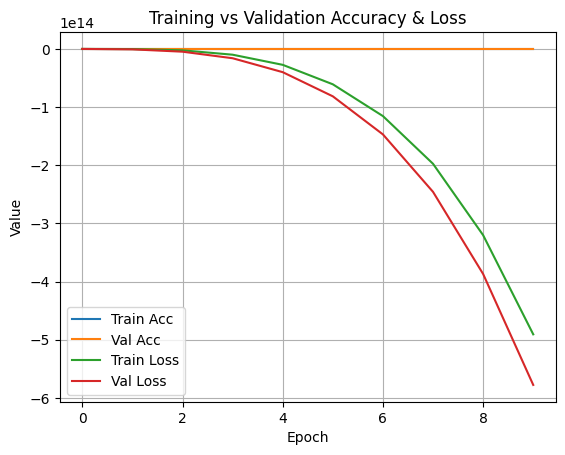

In [22]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
y_true = []
y_pred = []

for images, labels in val_ds.unbatch().batch(32):
    preds = model.predict(images)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend((preds > 0.5).astype(int).flatten())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 0s 45ms/step
[[   2  998    0]
 [   0 1000    0]
 [   2  998    0]]
              precision    recall  f1-score   support

      animal       0.50      0.00      0.00      1000
      avatar       0.33      1.00      0.50      1000
       human       0.00      0.00      0.00      1000

    accuracy                           0.33      3000
   macro avg       0.28      0.33      0.17      3000
weighted avg       0.28      0.33      0.17      3000



/home/lobral/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lobral/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lobral/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [31]:
# Define image path and target size
img_path = "data//my/human01.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [32]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
predicted_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 [==============================] - 0s 19ms/step
[[1.]]
1.0


NameError: name 'pred_label' is not defined

Predicted class: human


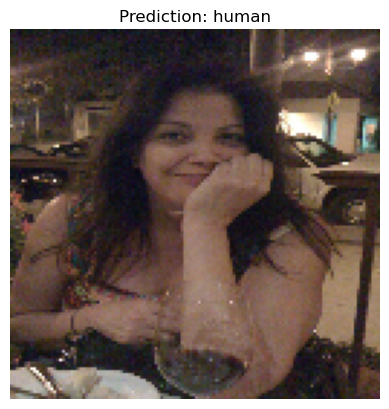

In [215]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

In [216]:
# Define image path and target size
img_path = "data\\my_pics\\20201225_185146443_iOS.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [217]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
pred_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.9898893
Predicted class: human


Predicted class: human


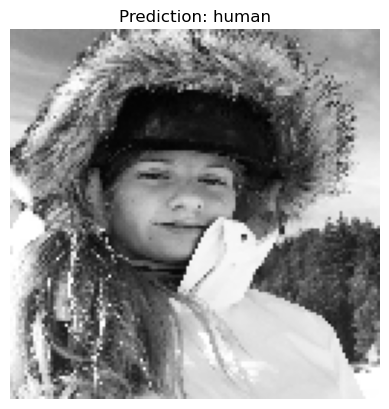

In [218]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

In [219]:
# Define image path and target size
img_path = "data\\my_pics\\Screenshot 2025-07-20 175956.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [220]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
predicted_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.9932005
Predicted class: human


Predicted class: human


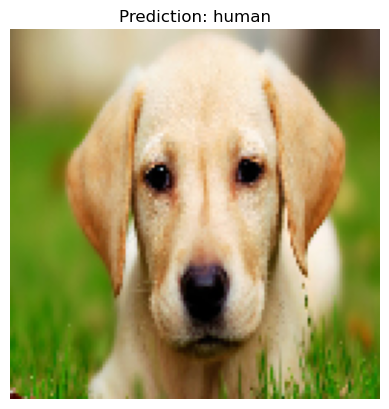

In [221]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

In [222]:
# Define image path and target size
img_path = "data\\my_pics\\Screenshot 2025-07-20 175818.jpg"
img_size = (128, 128)

# Load the image
img = image.load_img(img_path, target_size=img_size)

# Convert to array and add batch dimension
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize like training
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 128, 128, 3)

In [223]:
# Predict
prediction = model.predict(img_array)

# For binary classification, sigmoid output: closer to 0 = class 0, closer to 1 = class 1
predicted_label = int(prediction[0][0] > 0.5)
print(prediction[0][0])
print(f"Predicted class: {class_names[pred_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.9830573
Predicted class: human


Predicted class: human


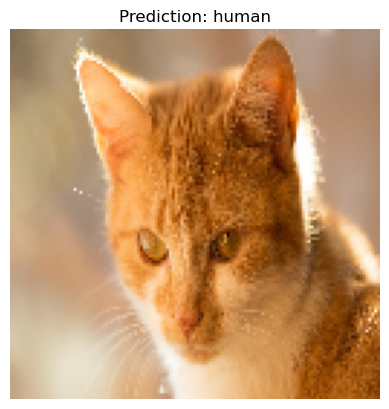

In [224]:
# Print the result using class_names
print(f"Predicted class: {class_names[predicted_label]}")

# Optional: show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_label]}")
plt.show()

# Transfer Learning with ResNet50

In [64]:
# Rebuild your datasets using ResNet50 preprocessing
# IMG_SIZE = (128, 128)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Step 1: Load raw dataset first (no mapping yet)
raw_train_ds = image_dataset_from_directory(
    "DATA/final/train",
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

# Step 2: Extract class names BEFORE mapping
class_names = raw_train_ds.class_names
print("Class names:", class_names)

# Step 3: Apply preprocessing and prefetch
train_ds = raw_train_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(buffer_size=AUTOTUNE)

val_ds = image_dataset_from_directory(
    "DATA/final/val",
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(lambda x, y: (preprocess_input(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze pretrained layers

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Found 24000 files belonging to 3 classes.
Class names: ['animal', 'avatar', 'human']
Found 3000 files belonging to 3 classes.


In [54]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight={0: 1.0, 1: 1.2, 2: 1.3}
)

Epoch 1/10
750/750 [==============================] - 38s 47ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 9.6331e-04 - val_accuracy: 0.9997
Epoch 2/10
750/750 [==============================] - 35s 46ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 3.5609e-04 - val_accuracy: 1.0000
Epoch 3/10
750/750 [==============================] - 35s 47ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 2.5415e-04 - val_accuracy: 1.0000
Epoch 4/10
750/750 [==============================] - 35s 46ms/step - loss: 4.6235e-04 - accuracy: 1.0000 - val_loss: 3.3442e-04 - val_accuracy: 1.0000
Epoch 5/10
750/750 [==============================] - 35s 46ms/step - loss: 4.0597e-04 - accuracy: 0.9999 - val_loss: 1.2782e-04 - val_accuracy: 1.0000
Epoch 6/10
750/750 [==============================] - 35s 46ms/step - loss: 9.0809e-04 - accuracy: 0.9996 - val_loss: 1.4491e-04 - val_accuracy: 1.0000
Epoch 7/10
750/750 [==============================] - 35s 47ms/step - loss: 0.0014 - accuracy: 0.999

In [55]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

94/94 [==============================] - 4s 38ms/step
[[316 331 353]
 [324 351 325]
 [360 318 322]]


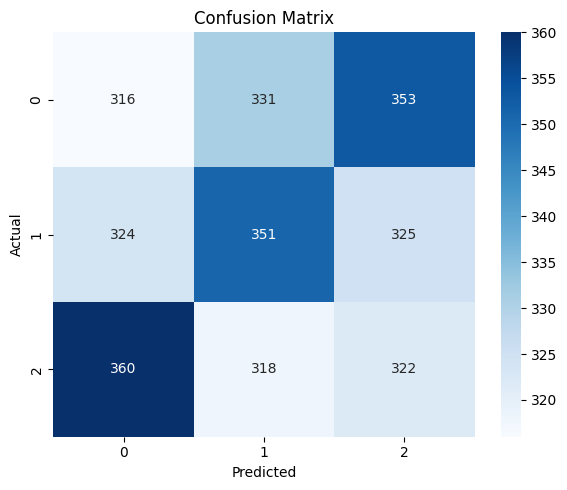

In [56]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    label = int(pred[0][0] > 0.5)
    print(f"Predicted: {class_names[label]} ({pred[0][0]:.4f})")

    plt.imshow(image.load_img(img_path))
    plt.title(f"{class_names[label]} ({pred[0][0]:.4f})")
    plt.axis("off")
    plt.show()

def predict_image_tta(path, n_flips=1):
    """
    Predict with simple test-time augmentation (original + horizontal flips).
    IMPORTANT: do NOT preprocess here — your model already does it inside.
    """
    img = keras.utils.load_img(path, target_size=IMG_SIZE, color_mode="rgb")
    x = keras.utils.img_to_array(img)[None, ...]  # (1, H, W, 3), 0..255

    views = [x]
    for _ in range(n_flips):
        views.append(x[:, :, ::-1, :])  # horizontal flip

    probs = []
    for v in views:
        probs.append(model.predict(v, verbose=0)[0])  # model graph handles preprocess_input
    probs = np.stack(probs, axis=0).mean(axis=0)

    idx = int(np.argmax(probs))
    return {
        "predicted_index": idx,
        "predicted_label": CLASS_NAMES_OUT[idx],
        "probs": {CLASS_NAMES_OUT[i]: float(probs[i]) for i in range(3)}
    }


In [5]:
from pathlib import Path

image_dir = Path('data/my')
for jpg_file in image_dir.glob('*.jpg'):
    print("Found:", jpg_file)
    predict_image(jpg_file)


Found: data/my/avatar01.jpg


NameError: name 'preprocess_input' is not defined